In [1]:
import pandas as pd    
import numpy as np     
from nltk.corpus import stopwords   
from sklearn.model_selection import train_test_split      
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences   
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Dropout, Dense, Conv1D, Bidirectional, LSTM, Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint   
from tensorflow.keras.models import load_model   
from sklearn.metrics import f1_score,precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import re

In [2]:
data = pd.read_csv('IMDB Dataset.csv')

print(data)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [3]:
english_stops = set(stopwords.words('english'))

In [4]:
def load_dataset():
    df = pd.read_csv('IMDB Dataset.csv')
    x_data = df['review']       
    y_data = df['sentiment']    

    x_data = x_data.replace({'<.*?>': ''}, regex = True)          
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops]) 
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   
    
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


In [5]:
for i in range(20):
    print("Review",i,  ' '.join(x_data[i]), y_data[i])

Review 0 one reviewers mentioned watching oz episode hooked they right exactly happened the first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid this show pulls punches regards drugs sex violence its hardcore classic use word it called oz nickname given oswald maximum security state penitentary it focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away i would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around the first episode i ever saw struck nasty surreal i say i ready i watched i developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
12878    [for, bewildered, length, pace, film, like, sh...
30021    [this, film, exceeded, expectations, i, though...
13751    [this, film, absolute, cinematic, genius, it, ...
5369     [i, saw, gary, busey, fred, williamson, thinki...
17511    [john, van, druten, bell, book, candle, deligh...
                               ...                        
39525    [two, women, sick, controlling, husbands, taki...
9399     [this, one, best, series, ranking, resident, e...
36685    [this, wonderful, movie, struggle, mormons, fi...
47190    [so, lets, say, producer, money, somehow, got,...
1477     [i, often, feel, like, scrooge, slamming, movi...
Name: review, Length: 40000, dtype: object 

45058    [nowhere, near, original, it, quite, accurate,...
30844    [for, homicide, junkies, movie, great, every, ...
5498     [unlike, spaghetti, westerns, one, characters,...
38812    [this, film, basically, velvet, goldmine, writ...
37033    [i, really, wanted, like, western, fan, genre,...
 

In [7]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [8]:
token = Tokenizer(lower=False)    
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[  204 11367  1456 ...     0     0     0]
 [    8     4 10183 ...     0     0     0]
 [    8     4  1511 ...     0     0     0]
 ...
 [    8   297     3 ...  9598   542  9860]
 [  146  1433    58 ...   721    97   848]
 [    1   310   135 ...     0     0     0]] 

Encoded X Test
 [[ 1175   643   118 ...     0     0     0]
 [  204  5888 12061 ...     0     0     0]
 [  927  4734  2562 ...     0     0     0]
 ...
 [    1    23   198 ...  1398    61   247]
 [  309   220   909 ...     0     0     0]
 [    1   657    36 ...     5    19   171]] 

Maximum review length:  130


In [9]:
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2956352   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,981,249
Trainable params: 2,981,249
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [50]:
model_history = model.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9902
Epoch 1: accuracy did not improve from 0.99138
313/313 [==============================] - 62s 198ms/step - loss: 0.0382 - accuracy: 0.9902
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9923
Epoch 2: accuracy improved from 0.99138 to 0.99235, saving model to models\LSTM.h5
313/313 [==============================] - 61s 196ms/step - loss: 0.0317 - accuracy: 0.9923
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9876
Epoch 3: accuracy did not improve from 0.99235
313/313 [==============================] - 68s 216ms/step - loss: 0.0532 - accuracy: 0.9876
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9789
Epoch 4: accuracy did not improve from 0.99235
313/313 [==============================] - 55s 176ms/step - loss: 0.0858 - accuracy: 0.9789
Epoch 5/5
313/313 [=========

In [51]:
model.save('models/LSTM.h5')

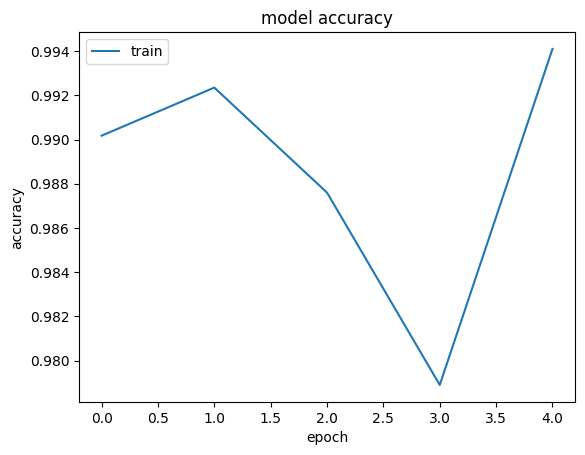

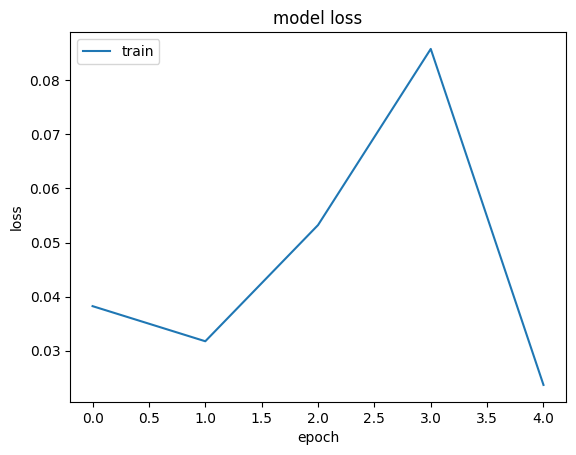

In [52]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

313/313 [==============================] - 7s 21ms/step
Correct Prediction: 8658
Wrong Prediction: 1342
Accuracy: 86.58


In [54]:
score = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 6s 21ms/step - loss: 0.5947 - accuracy: 0.8658


In [55]:
confusion_matrix(y_test, y_pred)

array([[4219,  670],
       [ 672, 4439]], dtype=int64)

In [17]:
F1_score = f1_score(y_test, y_pred)
Precision_score = precision_score(y_test, y_pred)
Recall_score = recall_score(y_test, y_pred)
print('F1_score: {}\nPrecision_score: {}\nRecall_score:{}'.format(F1_score, Precision_score, Recall_score))

F1_score: 0.8630271974773354
Precision_score: 0.8693666865197538
Recall_score:0.8567794952064175


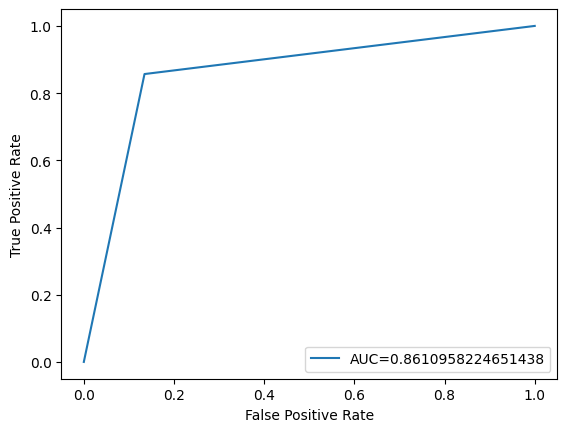

In [18]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [19]:
loaded_model = load_model('models/LSTM.h5')

In [45]:
review = str(input('Movie Review: '))
review_list = ['The score of the movie is stunning.', 'The first scene of the movie grabbed me at the first glance and took me to another world.', 
                "I don't like the way how the director decided to shoot this scene on that castle.", 'I found the girl on the movie very hot and breath-taking.', 
                'Nothing was typical about this. Everything was beautifully done in this movie, the story, the flow, the scenario, everything. I highly recommend it for mystery lovers, for anyone who wants to watch a good movie!']

In [46]:
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

print('Filtered: ', filtered)

Cleaned:  I absolutely adored this world that was created in the first film so I was beyond eager for a second movie  the sequel did not disappoint Ive heard a few negative reviews but I refuse to pay them much attention as this movie deserves its credit  Its such a beautiful important movie that holds important meanings in between the scenes and writing  the world that was created along with the creatures is nothing short of brilliant and beautiful I find myself craving to understand this world and these beings  they seem to live their lives so connected with nature and spirituality that this whole universe comes across as very appetizing to most  The comedy bits in this movie in particular were done so well and it added a surprising layer to the already magnificent watch I cant get enough of these movies and I cant wait for the rd  These are movies im comfortable with having  or  films  Maybe even a show Whatever this franchise has in store for the future im in full support and Ill b

In [47]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)

[[    1   319  9486    85   957    23     4     1   554  4377   245     3
    644  4468 15897   454  1514   732     1  5376   859    17   589     3
    900   997   727   218   562     3  1613   562  8557    60   396    85
    957   248  1975    76   236   425   218     1    79 10268   285    85
   3339   217   329   380  3141   814 13294   130  2239   180   524 31992
      2   111  1568     3   791   127    16  1155  1643  9039   371  1801
     33     1  2072    19   101    28     1  2072   764  3614   774    28
   4609  3991    35   175    11    45   769  2910   974   619  4609   270
   1370  1775  7325   983     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [48]:
result = loaded_model.predict(tokenize_words)
print(result)

1/1 [==============================] - 0s 44ms/step
[[0.7161515]]


In [49]:
if result >= 0.7:
    print('positive')
else:
    print('negative')

positive
